In [3]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from matplotlib import pyplot

sns.set()
sns.set(rc={'figure.figsize':(11.7,8.27)})

pd.set_option("display.max_columns", None)
pd.set_option('display.max_colwidth', None) #50 for truncated view, -1 for full view

In [4]:
SWaT_Dataset_Normal_v0 = pd.read_pickle('dataset/SWaT_Dataset_Normal_v0.pkl')
SWaT_Dataset_Normal_v1 = pd.read_pickle('dataset/SWaT_Dataset_Normal_v1.pkl')
SWaT_Dataset_Attack_v0 = pd.read_pickle('dataset/SWaT_Dataset_Attack_v0.pkl')

## Check difference between SWaT_Dataset_Normal_v0 and SWaT_Dataset_Normal_v1

In [5]:
print(len(SWaT_Dataset_Normal_v0))
print(len(SWaT_Dataset_Normal_v1))
print(len(SWaT_Dataset_Attack_v0))

496800
495000
449919


### Check difference between SWaT_Dataset_Normal_v0 and SWaT_Dataset_Normal_v1

In [6]:
d1 = SWaT_Dataset_Normal_v0.iloc[1800:]
d2 = SWaT_Dataset_Normal_v1.iloc[:]

In [7]:
d1 = d1.reset_index(drop=True)
d2 = d2.reset_index(drop=True)

In [8]:
d3 = pd.concat([d1['P1']['FIT101'], d2['P1']['FIT101']], axis=1)

In [9]:
d3['difference'] = d3.apply(lambda x: x[0] - x[1], axis=1)

In [10]:
d3['difference'].sum()

0.0

## Clean dataset

In [11]:
SWaT_Dataset_Attack_v0.columns = SWaT_Dataset_Normal_v0.columns

In [12]:
df = SWaT_Dataset_Normal_v0.append(SWaT_Dataset_Attack_v0)
df = df.reset_index(drop=True)

/tmp/ipykernel_6518/2082133822.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = SWaT_Dataset_Normal_v0.append(SWaT_Dataset_Attack_v0)


Create clean dataset

In [13]:
df = pd.concat([df['Unnamed: 0_level_0'], df['P1'], df['P2'], df['P3'], df['P4'], df['P5'], df['P6']], axis=1)

In [14]:
time_1 = df.iloc[len(df)-1].values[0]
print(time_1)
time_1 = pd.to_datetime(time_1, format='%d/%m/%Y %H:%M:%S %p')
time_1

 2/1/2016 2:59:59 PM


Timestamp('2016-01-02 02:59:59')

In [15]:
time_2 = df.iloc[0].values[0]
print(time_2)
time_2 = pd.to_datetime(time_2, format=' %d/%m/%Y %I:%M:%S %p')
time_2

 22/12/2015 4:00:00 PM


Timestamp('2015-12-22 16:00:00')

Add index column

In [16]:
df['index'] = [i for i in range(len(df))]

Clean Timestamp column

In [17]:
list(df.columns)[0]

' Timestamp'

In [18]:
df.rename(columns={' Timestamp':'Timestamp'}, inplace=True)

In [19]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format=' %d/%m/%Y %I:%M:%S %p')

Clean Normal/Attack column

In [20]:
df['Normal/Attack'].value_counts()

Normal     892098
Attack      54584
A ttack        37
Name: Normal/Attack, dtype: int64

In [21]:
typos = {
    "Attack": ["A ttack"],
}
c = "Normal/Attack"
for expected, founds in typos.items():
    for typo in founds:
        s = df[c] == typo
        df.loc[s, c] = expected

In [22]:
df['Normal/Attack'].value_counts()

Normal    892098
Attack     54621
Name: Normal/Attack, dtype: int64

In [23]:
for col in df.columns:
    if df[col].isna().sum() != 0:
        print(col, df[col].isna().sum())

## Feature Selection

### 1st Method

Check feature with a variance equal to zero

In [24]:
cols_numeric = list(df.columns)
cols_numeric.remove('Timestamp')
cols_numeric.remove('Normal/Attack')
cols_numeric.remove('index')
for col in cols_numeric:
    var = np.var(df[col])
    if var == 0:
        print(col)
        cols_numeric.remove(col)

P202
P401
P404
P502
P601
P603


remove feature with variance of 0

In [25]:
#df = df.drop(columns=['P202','P401','P404','P502','P601','P603'])

### 2nd Method

use anova feature selection : check variance to verify if there is a significant difference between groups

In [29]:
cols_numeric = list(df.columns)
cols_numeric.remove('Timestamp')
cols_numeric.remove('index')
data = df[cols_numeric]
X = data.iloc[:, :-1]
y = data.iloc[:,-1]

# https://machinelearningmastery.com/feature-selection-with-numerical-input-data/
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
print(y_train)

492147    Normal
911775    Normal
786294    Normal
782193    Normal
684115    Normal
           ...  
491263    Normal
791624    Normal
470924    Normal
491755    Normal
128037    Normal
Name: Normal/Attack, Length: 634301, dtype: object


/home/guillaume/.local/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [11 29 32 43 48 50] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/guillaume/.local/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Feature 0: 29672.377088
Feature 1: 45935.941346
Feature 2: 27293.914314
Feature 3: 41784.238427
Feature 4: 34448.563802
Feature 5: 41107.887615
Feature 6: 21727.052269
Feature 7: 121.508866
Feature 8: 40028.314796
Feature 9: 37563.870988
Feature 10: 1397.247074
Feature 11: nan
Feature 12: 41967.120368
Feature 13: 703.837531
Feature 14: 30364.315956
Feature 15: 687.450391
Feature 16: 48507.202492
Feature 17: 71027.651826
Feature 18: 17550.144510
Feature 19: 103.248411
Feature 20: 52022.189387
Feature 21: 39.938208
Feature 22: 246883.135722
Feature 23: 81.715438
Feature 24: 66588.765635
Feature 25: 3694.783998
Feature 26: 438987.336347
Feature 27: 752251.435751
Feature 28: 364015.503575
Feature 29: nan
Feature 30: 676087.971693
Feature 31: 2.385597
Feature 32: nan
Feature 33: 738942.770019
Feature 34: 262105.608383
Feature 35: 171586.439556
Feature 36: 553.725950
Feature 37: 5359.745671
Feature 38: 706877.403524
Feature 39: 692137.175161
Feature 40: 742596.594460
Feature 41: 751884.16182

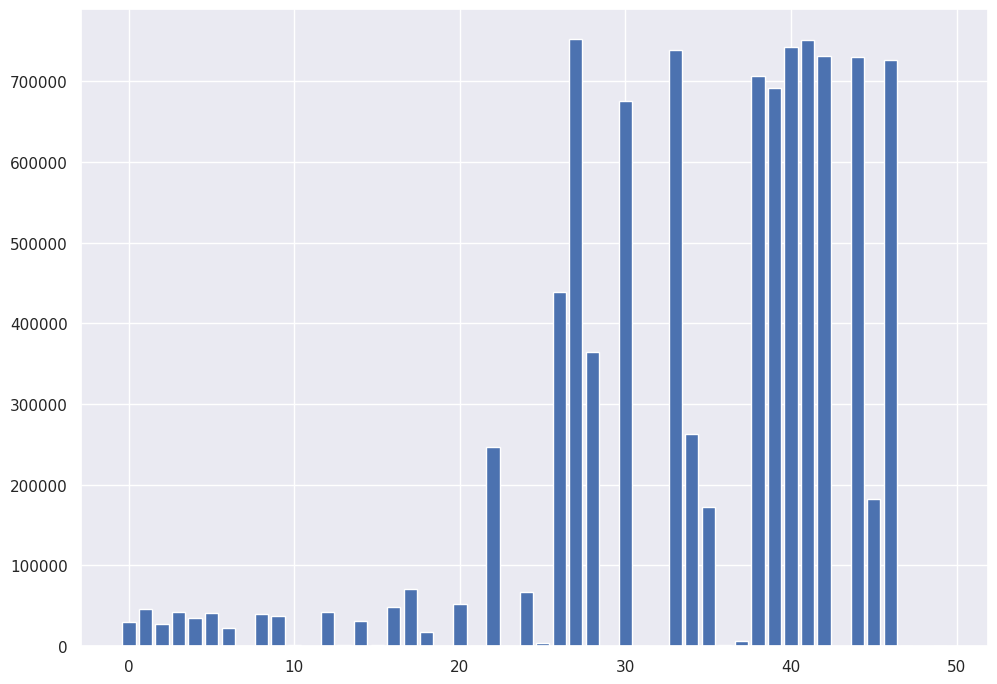

<class 'numpy.float64'>
29672.377088287452
45935.94134572472
27293.91431357528
41784.23842740317
34448.563801536024
41107.88761523779
21727.052268774896
121.50886610749043
40028.31479566484
37563.87098819906
1397.2470735296592
41967.12036847884
703.8375312207854
30364.315956354625
687.4503913919069
48507.20249226133
71027.65182565505
17550.14451041041
103.24841094960128
52022.18938677132
39.938207811704935
246883.1357217386
81.71543821279721
66588.76563469881
3694.783998386759
438987.33634717215
752251.4357510452
364015.50357519294
676087.9716932911
2.3855970075701913
738942.77001938
262105.60838305685
171586.43955599557
553.7259501155042
5359.74567102682
706877.4035239434
692137.1751610083
742596.5944596495
751884.1618218503
731974.92436744
730045.92205702
181476.4112034375
726872.1331516868
29.576854652292592
24.413632691663505
Number of features : 51, Numbers of feature with a NOVA score = 0 : 6
P403


In [45]:

fs = SelectKBest(score_func=f_classif, k='all')
# learn relationship from training data
fs.fit(X_train, y_train)
# transform train input data
X_train_fs = fs.transform(X_train)
# transform test input data
X_test_fs = fs.transform(X_test)


# what are scores for the features
for i in range(len(fs.scores_)):
	print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()
sum = 0
print(type(fs.scores_[3]))
for i in range(len(fs.scores_)):
	if ((fs.scores_[i])>1.0):
		print(fs.scores_[i])
		sum +=1 
print('Number of features : %d, Numbers of feature with a NOVA score = 0 : %d' % (len(fs.scores_),len(fs.scores_)-sum))
# This features are the same as detected with a variance of 0 above but there are still some very low scores

# print(cols_numeric[31]) P403
# df = df.drop('P403') 

## **Normalization of dataset**

In [25]:
cols_numeric = list(df.columns)
cols_numeric.remove('Timestamp')
cols_numeric.remove('Normal/Attack')
cols_numeric.remove('index')

mean normalization

In [26]:
data = df[cols_numeric]
mean_normalized_df = (data-data.mean())/data.std()

min-max normalization

In [27]:
data = df[cols_numeric]
min_max_normalized_df = (data-data.min())/(data.max()-data.min())

## Load list of attacks information

In [28]:
attacks_list_df = pd.read_csv('attacks_df.csv')

In [29]:
attacks_list_df['start_time'] = pd.to_datetime(attacks_list_df['start_time'])
attacks_list_df['end_time'] = pd.to_datetime(attacks_list_df['end_time'])
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

delta_time = pd.Timedelta(minutes=0)

df['attack'] = 0
for i in range(len(attacks_list_df)):
    attack_num = attacks_list_df.iloc[i]
    s = df['Timestamp'].between(attack_num['start_time'] - delta_time, attack_num['end_time'] + delta_time)
    df['attack'].loc[s] = attack_num['num_attack']

/tmp/ipykernel_5452/3300264022.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['attack'].loc[s] = attack_num['num_attack']


In [30]:
df.to_pickle('dataset/clean_dataset.pkl')